# PyBaMM Demo

In [1]:
import pybamm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
from scipy.integrate import solve_ivp
from scipy.fft import fft, fftfreq, fftshift
from scipy.signal import savgol_filter
from scipy.signal import find_peaks
from scipy import interpolate
plt.rcParams['figure.dpi'] = 150
plt.rcParams['savefig.dpi'] = 300
plt.style.use('seaborn-white')

eSOH_DIR = "./data/esoh/"
oCV_DIR = "./data/ocv/"
fig_DIR = "./figures/"


# Set Parameters and Expansion Functions

In [2]:
def nmc_volume_change_mohtat(sto, c_s_max):
    t_change = -1.10/100*(1-sto)
    return t_change

def graphite_volume_change_mohtat(sto, c_s_max):
    stoichpoints = np.array([0,0.12,0.18,0.24,0.50,1])
    thicknesspoints = np.array([0,2.406/100,3.3568/100,4.3668/100,5.583/100,13.0635/100])
    x = [sto]
    t_change = pybamm.Interpolant(stoichpoints, thicknesspoints, x, name=None, interpolator='linear', extrapolate=True, entries_string=None)
    return t_change

def get_parameter_values():
    parameter_values = pybamm.ParameterValues(chemistry=pybamm.parameter_sets.Mohtat2020)
    parameter_values.update(
        {
            # mechanical properties
            "Positive electrode Poisson's ratio": 0.3,
            "Positive electrode Young's modulus [Pa]": 375e9,
            "Positive electrode reference concentration for free of deformation [mol.m-3]": 0,
            "Positive electrode partial molar volume [m3.mol-1]": -7.28e-7,
            "Positive electrode volume change": nmc_volume_change_mohtat,
            # Loss of active materials (LAM) model
            "Positive electrode LAM constant exponential term": 2,
            "Positive electrode critical stress [Pa]": 375e6,
            # mechanical properties
            "Negative electrode Poisson's ratio": 0.2,
            "Negative electrode Young's modulus [Pa]": 15e9,
            "Negative electrode reference concentration for free of deformation [mol.m-3]": 0,
            "Negative electrode partial molar volume [m3.mol-1]": 3.1e-6,
            "Negative electrode volume change": graphite_volume_change_mohtat,
            # Loss of active materials (LAM) model
            "Negative electrode LAM constant exponential term": 2,
            "Negative electrode critical stress [Pa]": 60e6,
            # Other
            "Cell thermal expansion coefficient [m.K-1]": 1.48E-6,
            "Lower voltage cut-off [V]": 3.0,
            "Typical electrolyte concentration [mol.m-3]": 1200,
        },
        check_already_exists=False,
    )
    return parameter_values
parameter_values = get_parameter_values()

## Search Parameters

In [3]:
parameter_values.search("parallel")

Number of electrodes connected in parallel to make a cell	1.0


# Set Cell No

In [4]:
cell = 1

## Read Cell data

In [5]:
cell_no = f'{cell:02d}'
dfe=pd.read_csv(eSOH_DIR+"aging_param_cell_"+cell_no+".csv")
# Remove first RPT
dfe = dfe.drop(dfe.index[0])
dfe = dfe.reset_index(drop=True)
dfe['N']=dfe['N']-dfe['N'][0]
N =dfe.N.unique()
dfo_0=pd.read_csv(oCV_DIR+"ocv_data_cell_"+cell_no+".csv")
print("Cycle Numbers:")
print(*N, sep = ", ") 

Cycle Numbers:
0, 18, 57, 93, 134, 175, 216, 257, 298, 339


In [6]:
dfo = dfo_0[dfo_0['N']==N[0]]
# dfe_0 = dfe[dfe['N']==N[0]]
C_n_init = dfe['C_n'][0]
C_p_init = dfe['C_p'][0]
y_0_init = dfe['y_0'][0] 
if cell_no=='01':
    c_rate_c = '1C'
    c_rate_d = '1C'
    dis_set = " until 3V"
    # eps_n_data = 0.6234
    # eps_p_data = 0.4542
elif cell_no=='13':
    c_rate_c = 'C/5'
    c_rate_d = 'C/5'
    dis_set = " for 150 min"

# Set PyBaMM experiment

In [7]:
pybamm.set_logging_level("WARNING")
# pybamm.set_logging_level("NOTICE")
experiment = pybamm.Experiment(
    [
        ("Discharge at "+c_rate_c+" until 3V", )

    ],
    termination="50% capacity",
#     cccv_handling="ode",
)
spm = pybamm.lithium_ion.SPMe(
    {
        # "SEI": "ec reaction limited",
        # "loss of active material": ("stress-driven","none"),
        "loss of active material": "stress-driven",
        "stress-induced diffusion": "true",
        "pressure driven porosity": "true",
        # "lithium plating": "reversible",
    }
)
# spm.print_parameter_info()

In [8]:
param = spm.param
eps_n_data = parameter_values.evaluate(C_n_init*3600/(param.n.L * param.n.c_max * param.F* param.A_cc))
eps_p_data = parameter_values.evaluate(C_p_init*3600/(param.p.L * param.p.c_max * param.F* param.A_cc))
cs_p_init = parameter_values.evaluate(y_0_init* param.p.c_max)

## Set Additional Parameters

In [9]:
parameter_values = get_parameter_values()
parameter_values.update(
    {
        "SEI kinetic rate constant [m.s-1]": 1.6827e-16,
        "Positive electrode LAM constant proportional term [s-1]": 8.3569e-6,
        "Negative electrode LAM constant proportional term [s-1]": 5.8032e-5,
        "EC diffusivity [m2.s-1]": 2e-18,
        "Positive electrode LAM constant exponential term": 2,
        "Negative electrode LAM constant exponential term": 2,
        "Negative electrode active material volume fraction": eps_n_data,
        "Positive electrode active material volume fraction": eps_p_data,
    },
    check_already_exists=False,
)

In [10]:
spm.variables.search("overpotential")

Negative electrode lithium plating reaction overpotential
Negative electrode lithium plating reaction overpotential [V]
Negative electrode reaction overpotential
Negative electrode reaction overpotential [V]
Positive electrode reaction overpotential
Positive electrode reaction overpotential [V]
SEI film overpotential
SEI film overpotential [V]
X-averaged SEI film overpotential
X-averaged SEI film overpotential [V]
X-averaged battery concentration overpotential [V]
X-averaged battery reaction overpotential [V]
X-averaged concentration overpotential
X-averaged concentration overpotential [V]
X-averaged electrolyte overpotential
X-averaged electrolyte overpotential [V]
X-averaged negative electrode lithium plating reaction overpotential
X-averaged negative electrode lithium plating reaction overpotential [V]
X-averaged negative electrode reaction overpotential
X-averaged negative electrode reaction overpotential [V]
X-averaged positive electrode reaction overpotential
X-averaged positive 

# Simulate

In [11]:
sim_0 = pybamm.Simulation(spm, experiment=experiment, parameter_values=parameter_values, 
                            solver=pybamm.CasadiSolver("safe"))
sol_0 = sim_0.solve(initial_soc=0)

## Search for Variables

In [ ]:
spm.variables.search("potential")

Electrolyte potential
Electrolyte potential [V]
Gradient of electrolyte potential
Gradient of negative electrode potential
Gradient of negative electrolyte potential
Gradient of positive electrode potential
Gradient of positive electrolyte potential
Gradient of separator electrolyte potential
Negative current collector potential
Negative current collector potential [V]
Negative electrode lithium plating reaction overpotential
Negative electrode lithium plating reaction overpotential [V]
Negative electrode open circuit potential
Negative electrode open circuit potential [V]
Negative electrode oxygen open circuit potential
Negative electrode oxygen open circuit potential [V]
Negative electrode oxygen reaction overpotential
Negative electrode oxygen reaction overpotential [V]
Negative electrode potential
Negative electrode potential [V]
Negative electrode reaction overpotential
Negative electrode reaction overpotential [V]
Negative electrode surface potential difference
Negative electrode

# Quick Plot

In [ ]:
sol_0.plot()

interactive(children=(FloatSlider(value=0.0, description='t', max=3246.3160588083515, step=32.46316058808352),…

In [ ]:
output_variables = ["Terminal voltage [V]"]
sol_0.plot(output_variables=output_variables)

interactive(children=(FloatSlider(value=0.0, description='t', max=3246.3160588083515, step=32.46316058808352),…

In [ ]:
out_variables = ["Electrolyte concentration [mol.m-3]"]
sol_0.plot(output_variables=out_variables)
# plt.savefig(fig_DIR +'electrolyte_conc_porosity_0.png')

interactive(children=(FloatSlider(value=0.0, description='t', max=3246.3160588083515, step=32.46316058808352),…

In [ ]:
sol_0.plot([["Electrode current density", "Electrolyte current density"], "Terminal voltage [V]"])

interactive(children=(FloatSlider(value=0.0, description='t', max=3246.3160588083515, step=32.46316058808352),…

# Define plotting variables

In [ ]:
t = sol_0["Time [s]"].entries
I = sol_0["Current [A]"].entries
Q = -sol_0['Discharge capacity [A.h]'].entries
Vt = sol_0["Terminal voltage [V]"].entries
exp = 30e6*sol_0["Cell thickness change [m]"].entries
exp_n = 30e6*sol_0["Negative electrode thickness change [m]"].entries
exp_p = 30e6*sol_0["Positive electrode thickness change [m]"].entries
ee_p = sol_0["X-averaged positive electrode porosity"].entries
ee_n = sol_0["X-averaged negative electrode porosity"].entries
ee_s = sol_0["X-averaged separator porosity"].entries
j_n = sol_0["X-averaged negative electrode total interfacial current density [A.m-2]"].entries
j_p = sol_0["X-averaged positive electrode total interfacial current density [A.m-2]"].entries

x = sol_0["x [m]"].entries
c_e_0 = sol_0["Electrolyte concentration [mol.m-3]"].entries

Text(0, 0.5, 'Voltage [V]')

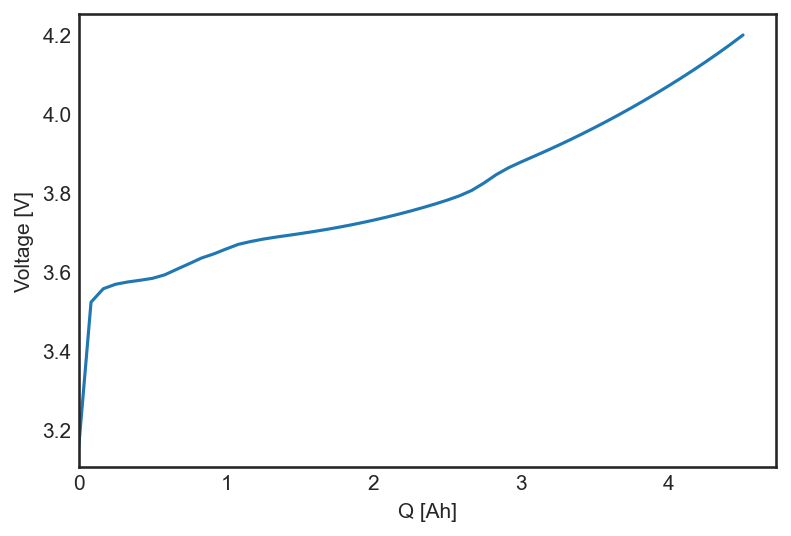

In [ ]:
plt.figure()
plt.plot(Q,Vt)
plt.xlim(left=0)
plt.xlabel('Q [Ah]')
plt.ylabel('Voltage [V]')

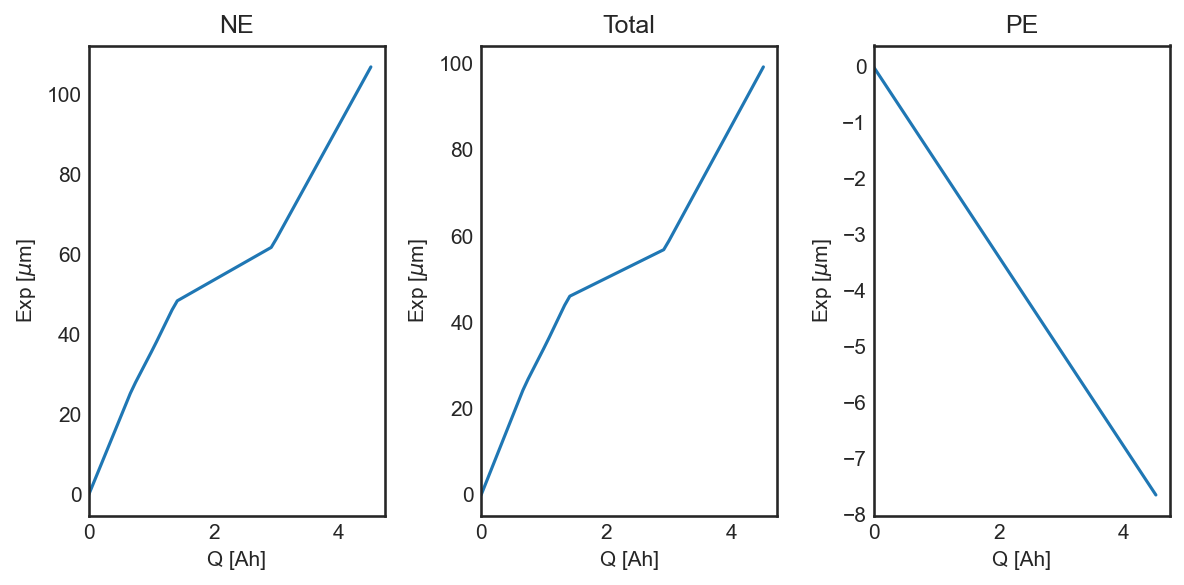

In [ ]:
fig = plt.figure(figsize=[8,4])
ax1 = plt.subplot(1,3,1)
ax1.plot(Q,exp_n)
ax1.set_xlim(left=0)
ax1.set_xlabel('Q [Ah]')
ax1.set_ylabel('Exp [$\mu$m]')
ax1.set_title('NE')
ax2 = plt.subplot(1,3,2)
ax2.plot(Q,exp)
ax2.set_xlim(left=0)
ax2.set_xlabel('Q [Ah]')
ax2.set_title('Total')
ax2.set_ylabel('Exp [$\mu$m]')
ax3 = plt.subplot(1,3,3)
ax3.plot(Q,exp_p)
ax3.set_xlim(left=0)
ax3.set_xlabel('Q [Ah]')
ax3.set_ylabel('Exp [$\mu$m]')
ax3.set_title('PE')
fig.tight_layout()